# Inception Modules

Since you already learned how to build a CNN using low-level TF libraries, we won't bother with that here. Let's use tf.layers to easily create our model. 

Let's first donwload our data. Also make sure you are running this notebook in GPU node.

In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [0]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar100.load_data()

In [0]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
y_train = y_train.ravel().astype('int64')
y_test = y_test.ravel().astype('int64')

In [0]:
conv2d = tf.layers.conv2d
max_pooling2d = tf.layers.max_pooling2d
average_pooling2d = tf.layers.average_pooling2d
relu = tf.nn.relu

Take a look at what the high-level architecture of our CNN is gonna look like.

In [0]:
def cnn_model_fn(features, labels, mode, params=None):
  
  # Reshape X to 4-D tensor: [batch_size, width, height, channels]
  input_layer = tf.reshape(features["x"], [-1, 32, 32, 3])
 
  # MODULE 1 - Output Tensor Shape: [batch_size, 32, 32, 96]
  mod1 = module1(input_layer)
  
  # Output Tensor Shape: [batch_size, 16, 16, 96]
  pool1 = max_pooling2d(inputs=mod1, pool_size=[2, 2], strides=2)
  
  # MODULE 2 - Output Tensor Shape: [batch_size, 16, 16, 96]
  mod2 = module2(pool1)
  
  # RESNET
  mod2 = pool1 + mod2

  # Output Tensor Shape: [batch_size, 16, 16, 24]
  conv = conv2d(inputs=mod2, filters=24, kernel_size=1,
                 padding='same', activation=relu)

  # Output Tensor Shape: [batch_size, 8, 8, 24]
  pool2 = average_pooling2d(inputs=conv, pool_size=2, strides=2)  
  
  # Output Tensor Shape: [batch_size, 8 * 8 * 24]
  pool2_flat = tf.reshape(pool2, [-1, 8 * 8 * 24])

  # Output Tensor Shape: [batch_size, 1000]
  dense = tf.layers.dense(inputs=pool2_flat, units=1000, activation=relu)
  
  dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

  # Output Tensor Shape: [batch_size, 100]
  logits = tf.layers.dense(inputs=dropout, units=100)

  loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
  
  
  # Don't worry about anything below ------------------------------------------

  predictions = {
      "classes": tf.argmax(input=logits, axis=1),
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
  }
  
  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.AdamOptimizer(learning_rate=params['lr'])
    train_op = optimizer.minimize(
        loss=loss,
        global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  if mode == tf.estimator.ModeKeys.EVAL:
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

This is going to be a naive module. We want 3 branches - one for each kernel dimension (1x1, 3x3, 5x5). Then we're going to do a depth-wise concatenation and return the output.

In [0]:
def module1(input_layer):
  # Input Tensor Shape: [batch_size, 32, 32, 3]
  
  # Output Tensor Shape: [batch_size, 32, 32, 32]
  branch1 = conv2d(inputs=input_layer, filters=32, kernel_size=1, 
                    padding="same", activation=relu)

  # Output Tensor Shape: [batch_size, 32, 32, 32]
  branch2 = conv2d(inputs=input_layer, filters=32, kernel_size=3, 
                    padding="same", activation=relu)

  # Output Tensor Shape: [batch_size, 32, 32, 32]
  branch3 = conv2d(inputs=input_layer, filters=32, kernel_size=5, 
                    padding="same", activation=relu)
  
  # Output Tensor Shape: [batch_size, 32, 32, 96]
  module = tf.concat([branch1, branch2, branch3], axis=3)
  
  return module

In [0]:
def module2(input_layer):
  # Input Tensor Shape: [batch_size, 16, 16, 96]
  
  # Output Tensor Shape: [batch_size, 16, 16, 24]
  branch1 = conv2d(inputs=input_layer, filters=24, kernel_size=1, 
                    padding="same", activation=relu)
  
  # Output Tensor Shape: [batch_size, 16, 16, 24]
  branch2 = conv2d(inputs=input_layer, filters=24, kernel_size=1, 
                    padding="same", activation=relu)
  branch2 = conv2d(inputs=branch2, filters=24, kernel_size=3, 
                    padding="same", activation=relu)

  # Output Tensor Shape: [batch_size, 16, 16, 24]
  branch3 = conv2d(inputs=input_layer, filters=24, kernel_size=1, 
                    padding="same", activation=relu)
  branch3 = conv2d(inputs=branch3, filters=24, kernel_size=5, 
                    padding="same", activation=relu)
  
  # Output Tensor Shape: [batch_size, 16, 16, 24]
  branch4 = max_pooling2d(inputs=input_layer, pool_size=3, 
                                     padding='same', strides=1)
  branch4 = conv2d(inputs=branch4, filters=24, kernel_size=1, 
                    padding="same", activation=relu)

  # Output Tensor Shape: [batch_size, 16, 16, 96]
  module = tf.concat([branch1, branch2, branch3, branch4], axis=3)
  
  return module


In [93]:
# Create the Estimator
classifier = tf.estimator.Estimator(model_fn=cnn_model_fn, params={'lr':0.001})

# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X_train},
    y=y_train,
    batch_size=250,
    num_epochs=None,
    shuffle=True)

# Evaluate the model
eval_input_fn = lambda X, y: tf.estimator.inputs.numpy_input_fn(
    x={"x": X},
    y=y,
    num_epochs=1,
    shuffle=False)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpyx1038ic', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f0a66338710>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [94]:
train_accs, val_accs = [], []
for i in range(5):
  classifier.train(input_fn=train_input_fn, steps=500 if i else 1)
  train_accs.append(classifier.evaluate(input_fn=eval_input_fn(X_train, y_train)))
  val_accs.append(classifier.evaluate(input_fn=eval_input_fn(X_test, y_test)))
  print('train acc:', train_accs[-1])
  print('val acc:', val_accs[-1])

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpyx1038ic/model.ckpt.
INFO:tensorflow:loss = 4.6426816, step = 1
INFO:tensorflow:Loss for final step: 4.6426816.
INFO:tensorflow:Starting evaluation at 2018-01-30-01:18:21
INFO:tensorflow:Restoring parameters from /tmp/tmpyx1038ic/model.ckpt-1
INFO:tensorflow:Finished evaluation at 2018-01-30-01:18:26
INFO:tensorflow:Saving dict for global step 1: accuracy = 0.0097, global_step = 1, loss = 4.62164
INFO:tensorflow:Starting evaluation at 2018-01-30-01:18:27
INFO:tensorflow:Restoring parameters from /tmp/tmpyx1038ic/model.ckpt-1
INFO:tensorflow:Finished evaluation at 2018-01-30-01:18:28
INFO:tensorflow:Saving dict for global step 1: accuracy = 0.0096, global_step = 1, loss = 4.622344
train acc: {'accuracy': 0.0097, 'loss': 4.62164, 'global_step': 1}
val acc: {'accuracy': 0.0096, 'loss': 4.622344, 'global_step': 1}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters

INFO:tensorflow:Restoring parameters from /tmp/tmpyx1038ic/model.ckpt-1001
INFO:tensorflow:Finished evaluation at 2018-01-30-01:20:41
INFO:tensorflow:Saving dict for global step 1001: accuracy = 0.3595, global_step = 1001, loss = 2.5595884
train acc: {'accuracy': 0.43576, 'loss': 2.2058916, 'global_step': 1001}
val acc: {'accuracy': 0.3595, 'loss': 2.5595884, 'global_step': 1001}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tmpyx1038ic/model.ckpt-1001
INFO:tensorflow:Saving checkpoints for 1002 into /tmp/tmpyx1038ic/model.ckpt.
INFO:tensorflow:loss = 2.2128716, step = 1002
INFO:tensorflow:global_step/sec: 8.71828
INFO:tensorflow:loss = 2.4708564, step = 1102 (11.479 sec)
INFO:tensorflow:global_step/sec: 8.78739
INFO:tensorflow:loss = 2.1918, step = 1202 (11.373 sec)
INFO:tensorflow:global_step/sec: 8.78059
INFO:tensorflow:loss = 2.456725, step = 1302 (11.391 sec)
INFO:tensorflow:global_step/sec: 8.7909
INFO:tensorflow:loss = 2.304408, step 

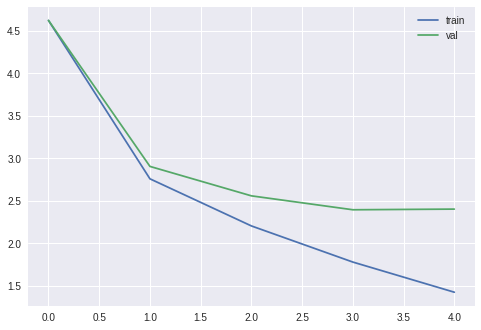

In [97]:
plt.plot([t['loss'] for t in train_accs], label='train')
plt.plot([t['loss'] for t in val_accs], label='val')
plt.legend()
plt.show()